# Co-relation analysis with arXiv abstracts

In [1]:
import sqlite3
import os
import pandas as pd
import numpy as np

import json
import tensorflow as tf
import tensorflow_text
import tensorflow_hub as hub
from keybert import KeyBERT

import pickle
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import ndcg_score

from nltk.tokenize import sent_tokenize

import warnings
warnings.filterwarnings('ignore')

import fasttext
import fasttext.util

import spacy

C:\Users\sri.sai.praveen.gadi\.virtualenvs\xxx-eAHl9Gue\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
query = 'Quantentechnologie'
query_search_arxiv = 'quantum technology'
query_updated = query.lower().replace(' ', '_')

sqlite_db_path = 'retrieval_test_dataset.db'
select_table_query = """SELECT * FROM retrieval_dataset where query='"""+query+"""'"""

with open(f'search_results_index/{query_updated}_bm25_result.json', 'r') as f:
    bm25_ranking = json.load(f)

with open(f'search_results_index/{query_updated}_semantic_result.json', 'r') as f:
    semantic_ranking = json.load(f)
    
    
dataframe_folder_path = f'dataframes/{query.lower()}/'
results_folder_path = f'results/{query.lower()}/'

final_df_filepath = dataframe_folder_path+'final_df.pkl'
arxiv_query_df_filepath = dataframe_folder_path+'arxiv_query_sent_df.pkl'

In [3]:
def sqlite_common_query_seq(sql_query, sql_select=False, sql_insert_params=None):

    print('running sqlite_common_query_seq')

    try:
        conn = sqlite3.connect(sqlite_db_path)

        cursor = conn.cursor()

        if sql_insert_params:
            cursor.execute(sql_query, sql_insert_params)
        else:
            cursor.execute(sql_query)

        if sql_select:
            query_result = cursor.fetchall()
            conn.close()

            return query_result

        conn.commit()
        conn.close()

        print('finished sqlite_common_query_seq')
    except Exception as e:
        print(e)

In [4]:
query_result = sqlite_common_query_seq(select_table_query, sql_select=True) 

running sqlite_common_query_seq


In [5]:
rank_df = pd.DataFrame(query_result, columns=['query', 'id', 'gt_rank'])
rank_df.sample(2)

,query,id,gt_rank
11,Quantentechnologie,210705_news_392072,2
5,Quantentechnologie,210705_news_304057,1


In [6]:
df_xlm = pd.read_pickle('final_dataframe.pkl')
df_xlm = df_xlm[['id', 'text', 'lang', 'title', 'pubDate', 'label', 'text_len']]
df_xlm.sample(2)

,id,text,lang,title,pubDate,label,text_len
10400,210705_news_486351,In gerade mal 120 Tagen will die neue stellver...,de,US-Vizegeneralstaatsanwältin: Strafverfolgung ...,2021-05-02 11:32:00,1,354
10813,210705_news_339750,"Die deutschen Netzbetreiber fürchten, dass die...",de,Brandbrief: Netzbetreiber fordern Umsteuern be...,2020-11-12 16:18:00,1,468


In [7]:
final_df = pd.concat([rank_df.set_index('id'),df_xlm.set_index('id')], axis=1, join='inner').reset_index()
final_df.sample(2)

,id,query,gt_rank,text,lang,title,pubDate,label,text_len
8,210705_news_357644,Quantentechnologie,2,Eine quantensichere Verbindung zweier Behörden...,de,Absolut abhörsicher: Quantensicher verschlüsse...,2020-12-03 10:20:00,1,427
0,210705_news_139039,Quantentechnologie,2,Das Bundesamt für Sicherheit in der Informatio...,de,BSI veröffentlicht Handlungsempfehlungen für P...,2020-03-27 12:26:00,1,338


In [8]:
def transform_gt_rank(rank):
    
    if rank == 1:
        return 3
    elif rank == 2:
        return 2
    elif rank == 3:
        return 1
    elif rank == 4:
        return 0
    
def get_rank_from_rank_df(idx):
    return rank_df[rank_df['id'] == idx]['gt_rank'].values[0]

In [32]:
final_df = pd.read_pickle(final_df_filepath)

In [9]:
final_df['gt_rank'] = final_df.apply(lambda x:get_rank_from_rank_df(x['id']), axis=1)

In [10]:
final_df['gt_rank'] = final_df.apply(lambda x:transform_gt_rank(x['gt_rank']), axis=1)
final_df['gt_rank'].value_counts()

1    12
2     5
3     4
Name: gt_rank, dtype: int64

In [11]:
gt_rank_df = final_df[['id', 'gt_rank']].sort_values('gt_rank', ascending=False)
gt_rank_df.head(2)

,id,gt_rank
5,210705_news_304057,3
9,210705_news_376449,3


# Performance evaluation using nDCG

1. BM25
2. Semantic search

In [12]:
bm25_doc_list = []
semantic_doc_list = []

for key, item in bm25_ranking.items():
    bm25_doc_list.append(item)

for key, item in semantic_ranking.items():
    semantic_doc_list.append(item)

In [13]:
gt_rank_bm25_df = gt_rank_df[gt_rank_df['id'].isin(bm25_doc_list)]
gt_rank_semantic_df = gt_rank_df[gt_rank_df['id'].isin(semantic_doc_list)]

In [14]:
def get_gt_ranking(df):
    return df.gt_rank.values

def get_gt_rank_for_id(idx):
    return gt_rank_df[gt_rank_df['id'] == idx]['gt_rank'].values[0]

def get_bm25_semantic_relevance():
    
    bm25_relevance = []
    semantic_relevance = []
    
    for key, item in bm25_ranking.items():
        bm25_relevance.append(get_gt_rank_for_id(item))
        
    for key, item in semantic_ranking.items():
        semantic_relevance.append(get_gt_rank_for_id(item))
        
    return np.asarray([bm25_relevance]), np.asarray([semantic_relevance])

def get_ndcg_scores(true_ranking, predicted_ranking):
    
    ndcg_15 = ndcg_score(true_ranking, predicted_ranking, k=15)
    ndcg_10 = ndcg_score(true_ranking, predicted_ranking, k=10)
    ndcg_5 = ndcg_score(true_ranking, predicted_ranking, k=5)
    
    print(f'NDCG@15 -- {ndcg_15}')
    print(f'NDCG@10 -- {ndcg_10}')
    print(f'NDCG@5 -- {ndcg_5}')

In [15]:
true_relevance_bm25 = np.asarray([get_gt_ranking(gt_rank_bm25_df)])
true_relevance_semantic = np.asarray([get_gt_ranking(gt_rank_semantic_df)])

bm25_relevance, semantc_relevance = get_bm25_semantic_relevance()

In [16]:
get_ndcg_scores(true_relevance_bm25, bm25_relevance)

NDCG@15 -- 0.8884657626415814
NDCG@10 -- 0.8262936413057995
NDCG@5 -- 0.7345577848667816


In [17]:
get_ndcg_scores(true_relevance_semantic, semantc_relevance)

NDCG@15 -- 0.8788977123201883
NDCG@10 -- 0.8148664326306773
NDCG@5 -- 0.7026810891499645


# Arxiv dataset loading

### https://arxiv.org/

1. Physics -- not related
2. Quantitative Biology -- not related
3. Quantitative Finance -- not related
4. Economics -- not related
<br>

5. Mathematics -- related
6. Computer Science -- related
7. Statistics -- related
8. Electrical Engineering and Systems Science -- related


In [4]:
articles = []
with open("arxiv-metadata-oai-snapshot.json", "r") as f:
    for l in f:
        d = json.loads(l)
        articles.append((d['id'], d['title'], d['abstract'], d['categories']))

In [5]:
arxiv_df = pd.DataFrame(articles, columns=['id', 'title', 'abstract', 'categories'])

In [6]:
arxiv_df.sample(2)

,id,title,abstract,categories
812472,1701.07064,Summatory relations and prime products for the...,The Stieltjes constants $\gamma_k(a)$ appear...,math.NT math.CV
1244707,2002.07284,Sharp Asymptotics and Optimal Performance for ...,We study convex empirical risk minimization ...,math.ST cs.IT eess.SP math.IT stat.ML stat.TH


In [27]:
def get_target_category(category):
    
    category_list = category.split(' ')
    main_categories = []
    
    for cat in category_list:
        main_categories.append(cat.split('.')[0])
    
    return main_categories

def get_category_label(category):
    
    for cat in category:
        if cat in target_list:
            return 1
    
    return 0

In [14]:
arxiv_df['main_categories'] = arxiv_df.apply(lambda x:get_target_category(x['categories']), axis=1)

In [15]:
final_main_categories = []

for main_cat in arxiv_df.main_categories.values:
    
    final_main_categories.extend(main_cat)

In [20]:
from collections import Counter

counter = Counter(final_main_categories)

In [21]:
counter['math']

756101

In [22]:
counter['cs']

645302

In [23]:
counter['stat']

117051

In [24]:
counter['eess']

55560

In [28]:
target_list = ['math', 'cs', 'stat', 'eess']

arxiv_df['category_list'] = arxiv_df.apply(lambda x:get_category_label(x['main_categories']), axis=1)

In [ ]:
arxiv_df.cate

In [17]:
Counter(final_main_categories)

Counter({'hep-ph': 165922,
         'math': 756101,
         'cs': 645302,
         'physics': 261021,
         'cond-mat': 433734,
         'gr-qc': 95077,
         'astro-ph': 365225,
         'hep-th': 152519,
         'hep-ex': 47982,
         'nlin': 41854,
         'q-bio': 44563,
         'quant-ph': 125828,
         'hep-lat': 25742,
         'nucl-th': 52382,
         'math-ph': 70688,
         'nucl-ex': 23259,
         'stat': 117051,
         'q-fin': 18991,
         'econ': 6444,
         'eess': 55560,
         'acc-phys': 49,
         'adap-org': 584,
         'chao-dyn': 2398,
         'patt-sol': 650,
         'dg-ga': 732,
         'solv-int': 1413,
         'bayes-an': 16,
         'comp-gas': 221,
         'alg-geom': 1423,
         'funct-an': 427,
         'q-alg': 1578,
         'ao-sci': 17,
         'atom-ph': 123,
         'chem-ph': 251,
         'plasm-ph': 38,
         'mtrl-th': 262,
         'cmp-lg': 894,
         'supr-con': 175})

In [56]:
# query_concept_list = ['quantum technology', 'quantentechnologie', 'quantem computing', 'quantencomputer']

In [99]:
def query_docs_sent(abstract):
    
    if query_search_arxiv not in abstract.lower():
        return 'NA'
    
    sentences = sent_tokenize(abstract)
    sentences_list = []
    
    for sent in sentences:
        if query_search_arxiv in sent.lower():
            sentences_list.append(sent)
    
    if len(sentences_list) == 0:
        return 'NA'
    else:
        return ' '.join(sentences_list)
    
def query_docs_tf(abstract):
    
    return abstract.lower().count(query_search_arxiv)

In [91]:
# arxiv_df['abstract_sents'] = arxiv_df.apply(lambda x:query_docs_sent(x['abstract']), axis=1)
# arxiv_df['abstract_len'] = arxiv_df.apply(lambda x:len(x['abstract_sents']), axis=1)

In [92]:
arxiv_df['quant_label'] = arxiv_df.apply(lambda x:query_docs_tf(x['abstract']), axis=1)

<AxesSubplot:>

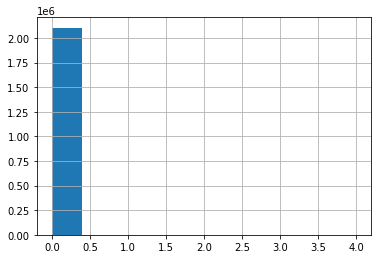

In [93]:
arxiv_df['quant_label'].hist()

In [94]:
# arxiv_df['quant_label'] = arxiv_df.apply(lambda x:query_docs(x['abstract']), axis=1)

31


<AxesSubplot:>

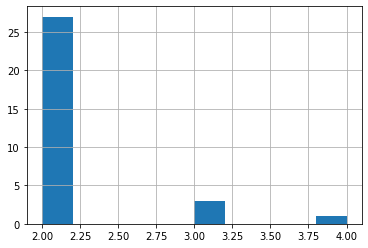

In [95]:
# quant_df = arxiv_df[arxiv_df['quant_label'] == 1]
quant_df = arxiv_df[arxiv_df['quant_label'] > 1]
print(len(quant_df.index))
quant_df['quant_label'].hist()

In [96]:
len(arxiv_df.index)

2104306

In [97]:
len(quant_df.index)

31

In [100]:
quant_df['abstract_sents'] = quant_df.apply(lambda x:query_docs_sent(x['abstract']), axis=1)

In [101]:
# quant_df['abstract_len'] = quant_df.apply(lambda x:len(x['abstract_sents']), axis=1)
# quant_df['abstract_len'].hist()

In [102]:
# quant_df.abstract_len.describe()

# I. Does manual labels correlate with arxiv abstracts? (cosine sim)

1. Co-relation analyis between ranked result vectors and mean/max abstracts vectors
2. Co-relation analyis between ranked result **noun-chunk** vectors and mean/max abstracts **noun-chunk** vectors
3. Co-relation analyis between ranked result **keyword** vectors and mean/max abstracts **keyword** vectors
4. Co-relation analyis between ranked result **paragraph** vectors and abstracts **summarization** vectors

In [103]:
# tf_model = hub.load(os.getcwd()+ '/../../models/USE_model')

In [104]:
def get_modified_vectors(vec_data):
    
    new_data = []
    for val in vec_data:
        new_data.append(val)
    
    new_data = np.array(new_data).reshape(-1, 512)
    return new_data

def get_document_vec(text):
    
    return tf_model(text)['outputs'].numpy()[0].reshape(1, -1)

def get_pool_vec(doc_vec_list, pool):
    
    doc_vec_list = get_modified_vectors(doc_vec_list)
    if pool == 'mean':
        return np.nanmean(doc_vec_list, axis=0)
    elif pool == 'max':
        return np.nanmax(doc_vec_list, axis=0)
    
def get_cosine_sim(vec_1, vec_2):
    
    return cosine_similarity(vec_1.reshape(1, -1), vec_2.reshape(1, -1))[0][0]

In [105]:
quant_df['doc_vec'] = quant_df.apply(lambda x:get_document_vec(x['abstract_sents']), axis=1)

In [106]:
# final_df['doc_vec'] = final_df.apply(lambda x:get_document_vec(x['text']), axis=1)

In [107]:
mean_doc_vec = get_pool_vec(quant_df.doc_vec.values, pool='mean')
max_doc_vec = get_pool_vec(quant_df.doc_vec.values, pool='max')

In [108]:
final_df['mean_sim'] = final_df.apply(lambda x:get_cosine_sim(x['doc_vec'], mean_doc_vec), axis=1)
final_df['max_sim'] = final_df.apply(lambda x:get_cosine_sim(x['doc_vec'], max_doc_vec), axis=1)

In [109]:
final_df['gt_rank'].corr(final_df['mean_sim'])

-0.2514190748671617

In [110]:
final_df['gt_rank'].corr(final_df['max_sim'])

-0.10121444522995372

In [111]:
# final_df[['gt_rank', 'mean_sim', 'max_sim']].sort_values('gt_rank')

#### 2. Co-relation analyis between ranked result **noun-chunk** vectors and mean/max abstracts **noun-chunk** vectors

In [112]:
nlp_de = spacy.load("de_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")

In [113]:
PRETRAINED_FASTTRACK_MODEL = os.getcwd()+ '/../../models/lid.176.bin'

LANG_EN = "__label__en"
LANG_DE = "__label__de"

fasttext.FastText.eprint = lambda x: None
# fasttext_model = fasttext.load_model(PRETRAINED_FASTTRACK_MODEL)

def detect_language(text):
    
    lang_label = fasttext_model.predict(text.replace("\n"," "))[0][0].split('__label__')[1]
    return lang_label

In [114]:
def get_nounchunks_vector(nounchunk_list):
    
    nounchunk_vec_list = []
    for nc in nounchunk_list:
        nounchunk_vec_list.append(get_document_vec(nc))
        
    return get_pool_vec(np.array(nounchunk_vec_list), pool='mean')

def get_noun_chunks(text, lang):
    
    doc = None

    try:
        if len(text) >= 999999:
            return None

        if lang == 'en':
            doc = nlp_en(text)
        elif lang == 'de':
            doc = nlp_de(text)
        else:
            return None
        
        noun_phrases_list = []
        
        for nc in doc.noun_chunks:
            noun_phrases_list.append(nc.lemma_) 
            
        return noun_phrases_list
    except Exception as e:
        print(e)
        return None

In [115]:
quant_df['lang'] = quant_df.apply(lambda x:detect_language(x['abstract_sents']), axis=1)

quant_df['noun_chunks'] = quant_df.apply(lambda x:get_noun_chunks(x['abstract_sents'], x['lang']), axis=1)
# final_df['noun_chunks'] = final_df.apply(lambda x:get_noun_chunks(x['text'], x['lang']), axis=1)

In [116]:
quant_df['nounchunk_mean_vec'] = quant_df.apply(lambda x:get_nounchunks_vector(x['noun_chunks']), axis=1)
# final_df['nounchunk_mean_vec'] = final_df.apply(lambda x:get_nounchunks_vector(x['noun_chunks']), axis=1)

mean_doc_vec_nounchunk = get_pool_vec(quant_df.nounchunk_mean_vec.values, pool='mean')
max_doc_vec_nounchunk = get_pool_vec(quant_df.nounchunk_mean_vec.values, pool='max')

final_df['mean_sim_nounchunk'] = final_df.apply(lambda x:get_cosine_sim(x['nounchunk_mean_vec'], mean_doc_vec_nounchunk), axis=1)
final_df['max_sim_nounchunk'] = final_df.apply(lambda x:get_cosine_sim(x['nounchunk_mean_vec'], max_doc_vec_nounchunk), axis=1)

In [117]:
final_df['gt_rank'].corr(final_df['mean_sim_nounchunk'])

0.21115233526485677

In [118]:
final_df['gt_rank'].corr(final_df['max_sim_nounchunk'])

0.026809977992466483

In [119]:
final_df[['gt_rank', 'mean_sim_nounchunk', 'max_sim_nounchunk']].sort_values('gt_rank')

,gt_rank,mean_sim_nounchunk,max_sim_nounchunk
10,0,0.907703,0.611960
18,0,0.881509,0.595990
17,0,0.905592,0.603056
16,0,0.891994,0.578404
14,0,0.906083,0.589287
13,0,0.895283,0.583553
12,0,0.877160,0.578992
20,0,0.890943,0.572797
6,0,0.838840,0.568291
4,0,0.888563,0.581538


In [120]:
noun_chunk_scores_df = final_df[['id', 'mean_sim_nounchunk']]
noun_chunk_scores_df.sample(2)

,id,mean_sim_nounchunk
4,210705_news_289800,0.888563
16,210705_news_488902,0.891994


In [121]:
bm25_nounchunk_ranking_df = pd.concat([noun_chunk_scores_df.set_index('id'),gt_rank_bm25_df.set_index('id')], axis=1, join='inner').reset_index()
semantic_nounchunk_ranking_df = pd.concat([noun_chunk_scores_df.set_index('id'),gt_rank_semantic_df.set_index('id')], axis=1, join='inner').reset_index()

In [122]:
bm25_nounchunk_ranking_df = bm25_nounchunk_ranking_df.sort_values(['mean_sim_nounchunk'], ascending=False)
semantic_nounchunk_ranking_df = semantic_nounchunk_ranking_df.sort_values(['mean_sim_nounchunk'], ascending=False)

In [123]:
bm25_nc_relevance = np.asarray([get_gt_ranking(bm25_nounchunk_ranking_df)])
semantic_nc_relevance = np.asarray([get_gt_ranking(semantic_nounchunk_ranking_df)])

In [124]:
get_ndcg_scores(true_relevance_bm25, bm25_nc_relevance)

NDCG@15 -- 0.8427884084594189
NDCG@10 -- 0.7428329474757139
NDCG@5 -- 0.6206178771639991


In [125]:
get_ndcg_scores(true_relevance_semantic, semantic_nc_relevance)

NDCG@15 -- 0.9023042696507532
NDCG@10 -- 0.8568591449409623
NDCG@5 -- 0.777237482687555


#### 3. Co-relation analyis between ranked result **keyword** vectors and mean/max abstracts **keyword** vectors

In [126]:
# kw_model = KeyBERT(model=tf_model)

from sentence_transformers import SentenceTransformer

# model = SentenceTransformer('sentence-transformers/paraphrase-xlm-r-multilingual-v1')
# kw_model = KeyBERT(model=model)

In [127]:
def get_top_keywords(text):
    
    return kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 2),
                              use_maxsum=True, nr_candidates=20, top_n=15)

def get_keywords_vector(keywords_list):
    
    keyword_vec_list = []
    for keyword in keywords_list:
        keyword_vec_list.append(get_document_vec(keyword[0]))
        
    return get_pool_vec(np.array(keyword_vec_list), pool='mean')

In [128]:
quant_df['keywords'] = quant_df.apply(lambda x:get_top_keywords(x['abstract_sents']), axis=1)
# final_df['keywords'] = final_df.apply(lambda x:get_top_keywords(x['text']), axis=1)

quant_df['keyword_mean_vec'] = quant_df.apply(lambda x:get_keywords_vector(x['keywords']), axis=1)
# final_df['keyword_mean_vec'] = final_df.apply(lambda x:get_keywords_vector(x['keywords']), axis=1)

mean_doc_vec_keyword = get_pool_vec(quant_df.keyword_mean_vec.values, pool='mean')
max_doc_vec_keyword = get_pool_vec(quant_df.keyword_mean_vec.values, pool='max')

final_df['mean_sim_keyword'] = final_df.apply(lambda x:get_cosine_sim(x['keyword_mean_vec'], mean_doc_vec_keyword), axis=1)
final_df['max_sim_keyword'] = final_df.apply(lambda x:get_cosine_sim(x['keyword_mean_vec'], max_doc_vec_keyword), axis=1)

In [129]:
final_df['gt_rank'].corr(final_df['mean_sim_keyword'])

-0.12332569018557901

In [130]:
final_df['gt_rank'].corr(final_df['max_sim_keyword'])

-0.09738077824388684

In [131]:
# final_df[['gt_rank', 'mean_sim_keyword', 'max_sim_keyword']].sort_values('gt_rank')

#### 4. Co-relation analyis between ranked result **paragraph** vectors and abstracts summarization vectors

In [132]:
from transformers import pipeline
model_name = 'deutsche-telekom/mt5-small-sum-de-en-v1'
summarizer = pipeline("summarization", model=model_name, tokenizer=model_name)

In [133]:
def get_summarization_text(text):
    return summarizer(text, min_length=50, max_length=100)[0]['summary_text']

def get_abstract_summarization_vectors(text):
    
    text_tokens = text.split()
    summarizer_vec_list = []
    
    if len(text_tokens) < 512:
        summarizer_vec_list.append(get_summarization_text(text))
    else:
        text_1 = ' '.join(text_tokens[:512])
        text_2 = ' '.join(text_tokens[512:])
        
        summarizer_vec_list.append(get_summarization_text(text_1))
        summarizer_vec_list.append(get_summarization_text(text_2))
        
    return get_nounchunks_vector(summarizer_vec_list)

def get_text_summarization_data(text):
    
    paragraph_vecs = []
    sentences = sent_tokenize(text)
    num_sent = 5
    
    for idx in range(0, num_sent, 5):
        idx_end = idx+5
        if idx_end < num_sent and num_sent-idx_end < 3:
            gt_sentences = sentences[idx:idx_end]
        else:
            gt_sentences = sentences[idx:]

        paragraph_vecs.append(get_document_vec(''.join(gt_sentences))) 
    
    
    sim_scores = []
    for paragraph_vec in paragraph_vecs:
        for gt_vec in quant_df.summarizer_vec:
            sim_scores.append(get_cosine_sim(paragraph_vec, gt_vec))

    return np.mean(np.array(sim_scores), axis=0)

In [134]:
quant_df['summarizer_vec'] = quant_df.apply(lambda x:get_abstract_summarization_vectors(x['abstract_sents']), axis=1) 

Your max_length is set to 100, but you input_length is only 93. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 100, but you input_length is only 92. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 100, but you input_length is only 96. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 100, but you input_length is only 66. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 100, but you input_length is only 71. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 100, but you input_length is only 64. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 100, but you input_length is only 55. You might consider

In [135]:
final_df['mean_sim_summ'] = final_df.apply(lambda x:get_text_summarization_data(x['text']), axis=1)
# final_df['max_sim_summ'] = final_df.apply(lambda x:get_cosine_sim(x['nounchunk_mean_vec'], max_doc_vec_summ), axis=1)

In [136]:
final_df['gt_rank'].corr(final_df['mean_sim_summ'])

-0.2941355783499731

In [137]:
# final_df.to_pickle('dataframes/quantum_technologie/final_df.pkl')
# quant_df.to_pickle('dataframes/quantum_technologie/quant_df.pkl')

## II. Can arxiv abstracts be used for knowledge set creation? (related keywords)